<a href="https://colab.research.google.com/github/jaydenchoe/Fundamentals-of-Deep-Learning-Book/blob/master/ch12_memory_augmented_nn/Ch12_MemoryAugmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementing the DNC in PyTorch

# PyTorch Code
Only the code printed in the book has been converted to PyTorch.  This notebook contains that code.

However, the entire code set needed to run the training and testing of bAbI has not yet been converted.  For reference, the complete codeset can be found at https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/tree/master/first_edition_archive/archive/dnc

The folder above contains the files referenced in the book:
- mem_ops.py
- preprocess.py
- train_babi.py
- test_babi.py

In [1]:
import torch
def Lt(L, wwt, p, N):

    L_t = torch.zeros((N,N), dtype=torch.float32)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            mask = torch.zeros((N,N), dtype=torch.float32)
            mask[i,j] = 1.0

            link_t = (1 - wwt[i] - wwt[j]) * L[i,j] + \
                      wwt[i] * p[j]
            L_t += mask * link_t
    return L_t

In [2]:
# sample test code
N = 10
L = torch.randn((N,N))
wwt = torch.randn(N)
p = torch.randn(N)

L_t = Lt(L, wwt, p, N)

In [3]:
def Lt(L, wwt, p, N):
    """
    returns the updated link matrix given the previous one along
    with the updated write weightings and the previous precedence
    vector
    """
    def pairwise_add(v):
        """
        returns the matrix of pairs - adding the elements of v to
        themselves
        """
        n = v.shape[0]
        # a NxN matrix of duplicates of u along the columns
        V = v.repeat(1,n)
        return V + V

    # expand dimensions of wwt and p to make matmul behave as outer
    # product
    wwt = torch.unsqueeze(wwt, 1)
    p = torch.unsqueeze(p, 0)

    I = torch.eye(N, dtype=torch.float32)
    return (((1 - pairwise_add(wwt)) * L +
             torch.matmul(wwt, p)) * (1 - I))

In [4]:
# sample test code
N = 10
L = torch.randn((N,N))
wwt = torch.randn(N)
p = torch.randn(N)

L_t = Lt(L, wwt, p, N)

In [5]:
# sample test input
ut = torch.randn((N))

sorted_ut, free_list = torch.topk(-1*ut, N)
sorted_ut *= -1

In [6]:
# sample test code
out_of_location_at = torch.rand(N)

empty_at = torch.empty(N)
a_t = empty_at.scatter(0, free_list, out_of_location_at)

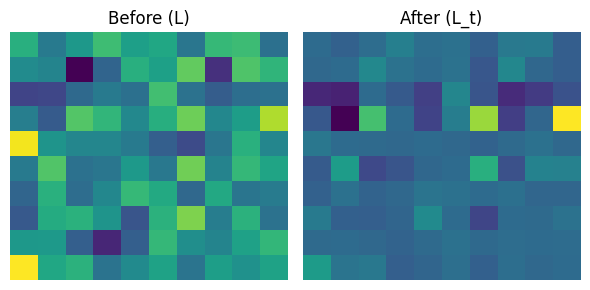

In [8]:
# 링크 행렬 업데이트 전후 비교 (교육용 시각화)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(L.detach().cpu(), aspect='auto')
plt.title("Before (L)"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(Lt(L, wwt, p, N).detach().cpu(), aspect='auto')
plt.title("After (L_t)"); plt.axis("off")

plt.tight_layout()
plt.show()

### 링크 행렬 업데이트 해설

- 행렬의 각 원소는 **메모리 슬롯 간 연결 강도(weight)** 를 나타냅니다.  
- 값이 클수록 색이 밝아지고(255에 가까움) 값이 작을수록 어두워집니다(0에 가까움).  
- **왼쪽 (Before L)**: 과거 연결이 여러 번 누적되어 값이 높아진 부분이 많아 전체적으로 밝게 보입니다.  
- **오른쪽 (After L_t)**: 최근 쓰기 정보를 반영하면서 불필요한 연결이 줄고, 핵심 연결만 남아 상대적으로 어두워졌습니다.  
- 즉 모델은 메모리를 단순히 저장하는 것이 아니라 **시간적 순서를 반영해 연결을 갱신**하고, 새로운 정보 중심으로 구조를 재편성합니다.
